# Actor-Critic
### Policy-based RL
- 업데이트의 대상이 정책
- Table형태의 정책 X -> function형태의 정책
- approximate된 정책의 input은 상태벡터, output은 각 행동을 할 확률
    - Discrete한 액션은 행동을 할 확률
    - Continous한 액션은 확률분포
- 확률적으로 행동을 선택(stochastic policy)
- 목적함수 $J(\theta)$ (=performance measure) : 정책에 대한 평가기준이 됨. 
    - 목적함수를 최대로 하는 정책을 습득하는 것
    - $J(\theta)$ : 에피소드 동안 받을 것이라고 기대하는 보상의 합
    
### Actor-Critic
- 스텝마다 업데이트를 수행
- 반환값의 수식이 아래와 같이 변경됨
    
$$G_t \rightarrow R_t + \gamma V_v (S_{t+1})$$
    
    
### Actor
- 정책을 근사 : $\theta$
- Adventage function(Bootstraping) -> Online

$$\nabla_{\theta}J(\theta) \sim \nabla_{\theta} log \pi_{\theta} (A_t|S_t) (R_t + \gamma V_{v}(S_{t+1}) - V_v (S_t))$$
    
### Critic
- 가치함수를 근사 : $v$

$$\nabla_{v}(r + \gamma V_v(s') - V_v(s))^2$$

### 기억할 점
- Actor가 Critic보다 수렴을 빨리하는 경향이 존재하므로, actor에 대한 lr을 critic보다 작게 설정하는 것이 좋음
- CNN의 경우 Feature extraction 부분을 Actor와 Critic이 Network를 공유함
- online-learning이기 때문에 샘플들 간의 상관관계가 높은 문제가 존재함

### 1. Import Libs

In [1]:
import datetime
import sys
import numpy as np
import os
import gym
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


### 2. Define Agent & Model

In [2]:
class A2CAgent:
    def __init__(self, state_sizes, action_size):
        self.render = False
        self.load_model = False
        
        self.state_sizes = state_sizes
        self.action_size = action_size
        self.value_size = 1 # critic에서 출력될 value의 size를 설정한 맴버변수
        
        self.discount_factor = 0.99
        self.actor_lr = 0.001 
        self.critic_lr = 0.003
        
        self.actor = self.build_actor()
        self.critic = self.build_critic()
        
        if self.load_model:
            self.actor.load_weights('./save_model/cartpole_actor.h5')
            self.critic.load_weights("./save_model/cartpole_critic.h5")
            
    # policy를 근사시키는 네트워크를 생성
    # 상태를 받고 각 행동에 대한 확률인 policy를 출력하는 모델임
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(24, input_dim = self.state_sizes, activation='relu', kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax', kernel_initializer='he_uniform'))
        actor.summary()
        actor.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.actor_lr))
        return actor
    
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim = self.state_sizes, activation='relu', kernel_initializer='he_uniform'))
        critic.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear', kernel_initializer='he_uniform'))
        critic.summary()
        critic.compile(loss='mse', optimizer=Adam(lr=self.critic_lr))
        return critic
    
    # 행동선택 policy
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]
    
    def train_model(self, state, action, reward, next_state, done):
        
        # target과 advantage를 numpy zero로 선언
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))
        
        # critic모델로부터 현재 state에 대한 value와 next_state에 대한 value를 산출함
        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]
        
        # 벨만기대방정식으로 업데이트
        if done:
            # action의 자료구조 : [[a1, a2, a3]]
            advantages[0][action] = reward - value
            # value [[value]]
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value
            
        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

### 3. Training

[2018-05-11 20:26:13,073] Making new env: CartPole-v1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 745
Trainable params: 745
Non-trainable params: 0
______________

episode :  211     score  : 500.0
episode :  212     score  : 500.0
episode :  213     score  : 500.0
episode :  214     score  : 500.0
episode :  215     score  : 500.0
episode :  216     score  : 455.0
episode :  217     score  : 20.0
episode :  218     score  : 60.0
episode :  219     score  : 49.0
episode :  220     score  : 36.0
episode :  221     score  : 186.0
episode :  222     score  : 280.0
episode :  223     score  : 287.0
episode :  224     score  : 276.0
episode :  225     score  : 185.0
episode :  226     score  : 209.0
episode :  227     score  : 216.0
episode :  228     score  : 243.0
episode :  229     score  : 206.0
episode :  230     score  : 366.0
episode :  231     score  : 500.0
episode :  232     score  : 500.0
episode :  233     score  : 500.0
episode :  234     score  : 500.0
episode :  235     score  : 500.0
episode :  236     score  : 500.0
episode :  237     score  : 500.0
episode :  238     score  : 500.0
episode :  239     score  : 500.0
episode :  240    

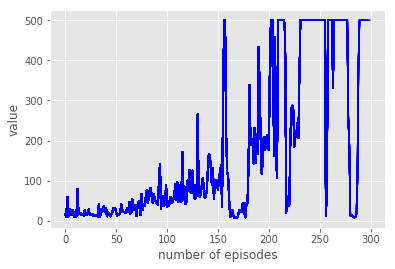

In [3]:
start = datetime.datetime.now()

EPISODES = 300

graph_path = os.path.join(os.getcwd(), 'save_graph')
model_path = os.path.join(os.getcwd(), 'save_model')

if not os.path.isdir(graph_path):
    os.mkdir(graph_path)
if not os.path.isdir(model_path):
    os.mkdir(model_path)

env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = A2CAgent(state_size, action_size)

scores, episodes = [], []

for episode in range(EPISODES):
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    
    # step별로 수행
    while True:
        if agent.render:
            env.render()

        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        
        reward = reward if not done or score == 499 else -100
        
        # 모델을 step마다 학습
        agent.train_model(state, action, reward, next_state, done)
        
        score += reward
        state = next_state
        
        # 에피소드가 끝나면
        if done:
            score = score if score == 500 else score + 100
            scores.append(score)
            episodes.append(episode)
            plt.plot(episodes, scores, 'b')
            plt.ylabel("value")
            plt.xlabel("number of episodes")
            plt.savefig('./save_graph/cartpole_a2c.png')
            print("episode : ", episode, "    score  :", score)
            
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                # sys.exit()
                agent.actor.save_weights("./save_model/cartpole_actor.h5")
                agent.critic.save_weights("./save_model/cartpole_critic.h5")
                env.render = True
                
            else:
                env.render = False
            break
            
    if episode % 50 == 0:
        agent.actor.save_weights("./save_model/cartpole_actor.h5")
        agent.critic.save_weights("./save_model/cartpole_critic.h5")
        
env.close()
end = datetime.datetime.now()
elapsed = end - start
print(elapsed)

- 4분 10초